In [2]:
addpath('C:\Users\barry\Documents\Academics\Quantecon-Notes\functions')
addpath('C:\Users\barry\Documents\Academics\Quantecon-Notes\functions\CEtools')
addpath('C:\Users\barry\Documents\Academics\Quantecon-Notes\functions\CEtools\public')
cd 'C:\Users\barry\Documents\Academics\Quantecon-Notes\functions'

> In path (line 109)
  In addpath (line 86)



# Growth model with investment specific shock

This notebook replicates a simplified model from *The role of investment-specific technological change in the business cycle (Greenwood, Hercowitz, and Krusell 1998)*


### Model setup
Suppose instead of a standard optimal growth model, we focus on two different types of capital: structure and equipment. Each type of capital is subject to different growth process given investment and contribute to the output differently. Specifically, suppose the in-period utility of consumption is $u(c) = \log(c)$. Denote the structure and equipment capital $k_s$ and $k_e$, respectively. The investments to structure and equipments are $i_s$ and $i_e$. (Here we ignore labor)

The stochastic growth problem (in the form of Bellman equation) is 
$$
V(k_s, k_e,q) = \max_{c,i_s,i_e} \frac{c^{1-\eta}}{1-\eta} + \beta E_q[V(k_s', k_e',q')]
$$
subject to 
$$
c+i_s+i_e = k_s^{\alpha_s}k_e^{\alpha_e}\\
k_s' = (1-\delta)k_s + i_s \\
k_e' = (1-\delta)k_e + e^q i_e \\
c\geq 0, i_s \geq 0, i_e \geq 0
$$

Using the first constraint we can replace $c$ in the Bellman equation
$$
V(k_s, k_e,q) = \max_{c,i_s,i_e} \frac{(k_s^{\alpha_s}k_e^{\alpha_e} - i_s - i_e)^{1-\eta}}{1-\eta} + \beta E_q[V(k_s', k_e',q')]
$$

Following Greenwood-Hercowitz-Krusell, we set following parameters: $\alpha_e = 0.18, \alpha_s = 0.12, \beta = 0.97, \delta_s = 0.056, \delta_e = 0.13, \eta =2 $

>In this economy, there is a shock to the efficiency of new capital produced (investment-specific technical change). A rise in $q$ is an improvement in the quality of $new$ capital goods because the same raw unit of investment goods have a larger impact on the capital stock used in production. In a competitive equilibrium, $q$ is the (log of the) price of consumption (and structure) $p_c$ relative to the price of equipment ($p_e$), i.e. $q_t = \log(\frac{p_{ct}}{p_{et}})$. As equipment quality improves relative to the (fixed) quality of consumption and structure, its relative price falls. 

### 1. Parameterize the process of $e^q$ using Fred data

In [3]:
cd 'C:\Users\barry\Documents\Academics\Quantecon-Notes'
% first column is price index of personal nondurable consumption
% second column is price index of private fixed investment
data = csvread('technological_shock.csv',1,1); 
data(end,:) = [];


% apply HP filter with smoothing parameter 1600 for quarterly data
[T,C] = hpfilter(log(data(:,1) ./ data(:,2)), 1600);

% Estimate an AR(1) process on the business cycle component
mdl = arima(1,0,0);
est_model = estimate(mdl,C);

 
    ARIMA(1,0,0) Model (Gaussian Distribution):
 
                   Value       StandardError    TStatistic      PValue   
                ___________    _____________    __________    ___________

    Constant    -2.3954e-05     0.00074247      -0.032262         0.97426
    AR{1}           0.83727       0.032022         26.146     1.0854e-150
    Variance      0.0001131     6.4852e-06          17.44      4.0877e-68




In [6]:
% Approximate the AR(1) using 10 grids
rho = 0.84;
sigma = 0.0001;

m = 10;
[q, w] = qnwlogn(m,0,sigma^2/(1-rho^2));


### 2. Solve the model

We use the Compecon matlab package in Miranda and Fackler (2004)

In [41]:
cd 'C:\Users\barry\Documents\Academics\Quantecon-Notes\functions'

In [118]:
%%file functions\tech_shock.m
function [out1, out2, out3] = tech_shock(flag,s,x,q,ae,as,delta_e,delta_s,eta)
n = size(s,1);
ds = 2;
dx = 2;
switch flag
case 'b' %boundary condition of choice variable at different state point
out1 = 0.0001*ones(size(s));
out2 = [s(:,1).^(as).*s(:,2).^(ae) s(:,1).^(as).*s(:,2).^(ae)];
case 'f'
out1 = zeros(n,1);
out2 = zeros(n,dx);
out3 = zeros(n,dx,dx);
out1 = (s(:,1).^as.*s(:,2).^ae - x(:,1) - x(:,2)).^(1-eta)/(1-eta);
out2(:,1) = -(s(:,1).^as.*s(:,2).^ae - x(:,1) - x(:,2)).^(-eta);
out2(:,2) = -(s(:,1).^as.*s(:,2).^ae - x(:,1) - x(:,2)).^(-eta);
out3(:,1,1) = -eta.*(s(:,1).^as.*s(:,2).^ae - x(:,1) - x(:,2)).^(-eta-1);
out3(:,2,1) = -eta.*(s(:,1).^as.*s(:,2).^ae - x(:,1) - x(:,2)).^(-eta-1);
out3(:,1,2) = -eta.*(s(:,1).^as.*s(:,2).^ae - x(:,1) - x(:,2)).^(-eta-1);
out3(:,2,2) = -eta.*(s(:,1).^as.*s(:,2).^ae - x(:,1) - x(:,2)).^(-eta-1);
case 'g'
out1 = zeros(n,ds);
out2 = zeros(n,ds,dx);
out3 = zeros(n,ds,dx,dx);
out1 = [(1-delta_s).*s(:,1) + x(:,1) (1-delta_e).*s(:,2) + q.*x(:,2)];
out2(:,1,1) = ones(n,1);
out2(:,2,2) = q.*ones(n,1);
end

Created file 'C:\Users\barry\Documents\Academics\Quantecon-Notes\functions\tech_shock.m'.


In [7]:
ae = 0.18;
as = 0.12;
delta_e = 0.13;
delta_s = 0.056;
beta = 0.97;
eta = 0.9;

model.func = 'tech_shock';
model.discount = beta;
model.e = q;
model.w = w;
model.params = {ae as delta_e delta_s eta};

n = [4 20];
smin = [0.01 0.01];
smax = [20 20];
fspace = fundefn('spli',n,smin,smax);
scoord = funnode(fspace);
snodes = gridmake(scoord);

qstar = 1;
xinit = ones(size(snodes));
vinit = 0.1.*zeros(size(snodes(:,1)));

In [10]:
qstar = 1;
sstar = [(delta_s/(as*(delta_s*ae/(delta_e*as)))^ae)^(ae+as-1) (delta_e/(ae*(delta_e*as/(delta_s*ae)))^as)^(ae+as-1)];
xstar = [sstar(1)*delta_s sstar(2)*delta_e];
pstar = [0 0];
[vlq,xlq,plq,ss,xx,pp] = lqapprox(model,snodes,sstar,xstar,pstar);
[c,s,v,x] = dpsolve(model, fspace, snodes, vlq, xlq);

  Running this M file version may be significantly slower and more memory intensive.
  Use MEXALL to create the executable (MEX or DLL) and make sure it is on the MATLAB path.
   1    1.5e+02
   2    1.2e+02
   3    3.6e-10
Elapsed Time =    6.74 Seconds



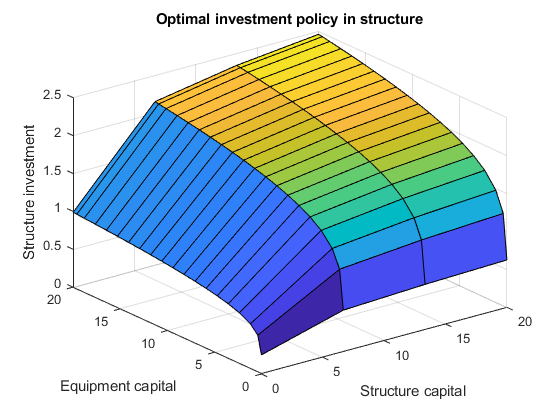

In [144]:
figure(1)
hh = surf(s{1},s{2},x(:,:,1)');
title('Optimal investment policy in structure')
xlabel('Structure capital');
ylabel('Equipment capital');
zlabel('Structure investment')

### 3. Simulation of expected capital growth

In [147]:
nyrs = 20;
nrep = 1000;
sinit = smin(ones(nrep,1),:);
[spath,xpath] = dpsimul(model, sinit, nyrs, s,x);

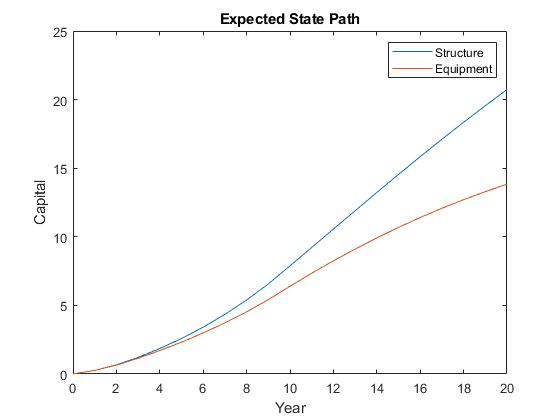

In [151]:
s1path = squeeze(spath(:,1,:));
s2path = squeeze(spath(:,2,:));
xpath = squeeze(xpath(:,1,:));

figure(4)
plot(0:nyrs, mean(s1path),0:nyrs, mean(s2path));
title('Expected State Path');
xlabel('Year');
legend('Structure', 'Equipment')
ylabel('Capital')